In [6]:
# Krok 1: Import bibliotek
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt


In [7]:
# Krok 2: Wczytanie danych
df = pd.read_csv("synthetic_health_data.csv")
X = df[["wiek", "BMI", "aktywnosc", "kalorie", "sen"]]
y = df[["cukier", "cisnienie_skurczowe", "cisnienie_rozkurczowe"]]


In [8]:
# Krok 3: Podział danych na treningowe i testowe
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
# Krok 4: Definicja modeli bazowych
rf = RandomForestRegressor(random_state=42)
xgb = XGBRegressor(random_state=42)
stack = StackingRegressor(
    estimators=[('rf', rf), ('xgb', xgb)],
    final_estimator=LinearRegression()
)


In [10]:
# Krok 5: Trenowanie i ewaluacja modeli (dla każdej zmiennej osobno)
results = {}

targets = ["cukier", "cisnienie_skurczowe", "cisnienie_rozkurczowe"]

for name, model in models.items():
    scores = []
    for target in targets:
        model.fit(X_train, y_train[target])
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test[target], y_pred)
        scores.append(r2)
    avg_r2 = np.mean(scores)
    results[name] = avg_r2
    print(f"{name} średni R²: {avg_r2:.4f}")


Random Forest średni R²: 0.7685
XGBoost średni R²: 0.7548
Stacking średni R²: 0.7717


In [13]:
# Krok 6: Tuning hiperparametrów dla XGBoost
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 5, 7]
}
grid = GridSearchCV(XGBRegressor(random_state=42), param_grid, cv=3, scoring='r2')
grid.fit(X_train, y_train)
best_xgb = grid.best_estimator_
print("Najlepszy XGBoost:", grid.best_params_)


Najlepszy XGBoost: {'max_depth': 3, 'n_estimators': 50}


In [14]:
# Krok 7: Dodanie nowego modelu do stackingu (np. KNN)
from sklearn.neighbors import KNeighborsRegressor

targets = ["cukier", "cisnienie_skurczowe", "cisnienie_rozkurczowe"]
r2_scores_stack2 = []

for target in targets:
    stack2 = StackingRegressor(
        estimators=[
            ('rf', rf),
            ('xgb', best_xgb),
            ('knn', KNeighborsRegressor())
        ],
        final_estimator=LinearRegression()
    )
    
    stack2.fit(X_train, y_train[target])
    y_pred = stack2.predict(X_test)
    r2 = r2_score(y_test[target], y_pred)
    r2_scores_stack2.append(r2)

avg_r2_stack2 = np.mean(r2_scores_stack2)
results["Stacking + KNN"] = avg_r2_stack2
print(f"Stacking + KNN średni R² score: {avg_r2_stack2:.4f}")


Stacking + KNN średni R² score: 0.7842


In [15]:
# Krok 8: Testowanie modeli na zbiorze danych Wine
from sklearn.datasets import load_wine

wine = load_wine()
X_wine = pd.DataFrame(wine.data, columns=wine.feature_names)
y_wine = pd.DataFrame(wine.target)

Xw_train, Xw_test, yw_train, yw_test = train_test_split(X_wine, y_wine, test_size=0.2, random_state=42)

# Ponieważ mamy klasyfikację, przetestujemy XGBoost jako klasyfikator
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf_rf = RandomForestClassifier(random_state=42)
clf_xgb = XGBClassifier(random_state=42)
clf_stack = StackingClassifier(
    estimators=[('rf', clf_rf), ('xgb', clf_xgb)],
    final_estimator=LogisticRegression()
)

clf_models = {
    "Random Forest (wine)": clf_rf,
    "XGBoost (wine)": clf_xgb,
    "Stacking (wine)": clf_stack
}

for name, clf in clf_models.items():
    clf.fit(Xw_train, yw_train.values.ravel())
    y_pred = clf.predict(Xw_test)
    acc = accuracy_score(yw_test, y_pred)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")


Random Forest (wine) Accuracy: 1.0000
XGBoost (wine) Accuracy: 0.9444
Stacking (wine) Accuracy: 1.0000


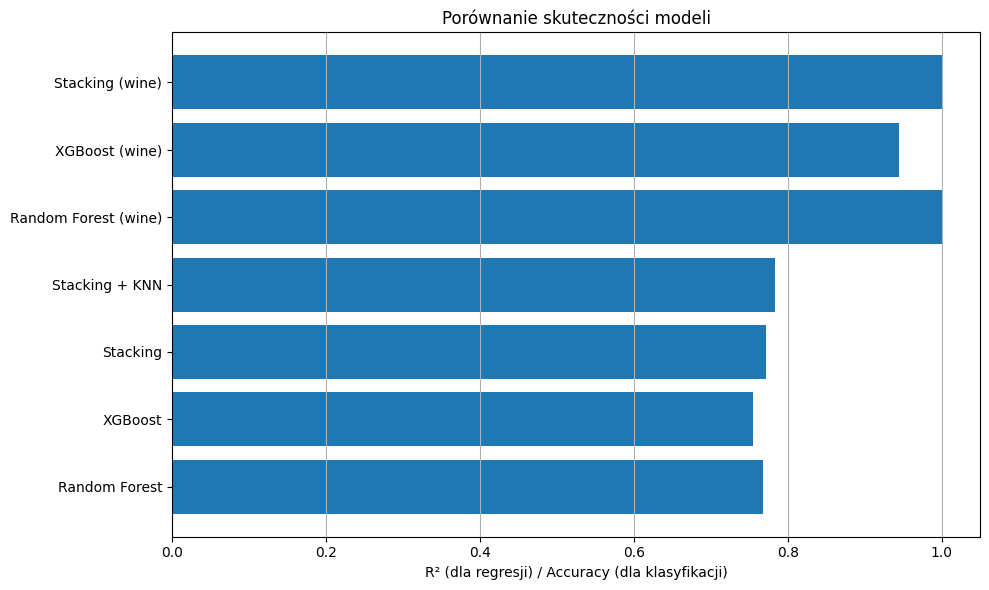

In [16]:
# Krok 9: Wykres porównujący dokładność/R² modeli
plt.figure(figsize=(10, 6))
labels = list(results.keys())
scores = list(results.values())

plt.barh(labels, scores)
plt.xlabel("R² (dla regresji) / Accuracy (dla klasyfikacji)")
plt.title("Porównanie skuteczności modeli")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()
